<a href="https://www.kaggle.com/code/debarhyaroy11707/roy-tummala-23-24-alzheimer-s-classification?scriptVersionId=168481516" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import necessary libraries
import matplotlib.pyplot as plt

# import CNNs from tensorflow
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception 
from tensorflow.keras.applications.densenet import DenseNet169

# import other tensorflow modules
from tensorflow.keras.layers import Dense, Flatten, InputLayer, MaxPool2D, Conv2D, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

# import modules for CBAM
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Input
from tensorflow.keras.layers import Activation, Concatenate, Multiply

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Split the data for the 4 classes with 70% going into training, 20% going into testing, and 10% for validation
dataset_path = "/kaggle/input/data01/Data copy" 
training = image_dataset_from_directory(dataset_path,
    labels='inferred',
    label_mode='categorical',
    class_names=['Very mild Dementia', 'Non Demented', 'Moderate Dementia', 'Mild Dementia'],
    color_mode='rgb',
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
validation = image_dataset_from_directory(dataset_path,
    labels='inferred',
    label_mode='categorical',
    class_names=['Very mild Dementia', 'Non Demented', 'Moderate Dementia', 'Mild Dementia'],
    color_mode='rgb',
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
size = tf.data.experimental.cardinality(validation)
testing = validation.take((2*size) // 3)
validation = validation.skip((2*size) // 3)

Found 19880 files belonging to 4 classes.
Using 13916 files for training.
Found 19880 files belonging to 4 classes.
Using 5964 files for validation.


In [3]:
"""
Implementation of CBAM: Convolutional Block Attention Module in the TensorFlow 2.5. by nikhilroxtomar
Github: https://github.com/nikhilroxtomar/Attention-Mechanism-Implementation/blob/main/TensorFlow/cbam.py
Paper: https://arxiv.org/pdf/1807.06521
"""

def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

In [4]:
# Concatenates several layers onto the pre-trained model including the attention mechanism
def seqLayers(x):
    x = cbam(x)
    x = Conv2D(filters=224, kernel_size=2, input_shape= (224,224,3))(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(2, 2), padding='same')(x)

    x = cbam(x)
    x = Conv2D(filters=224, kernel_size=2)(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(2, 2), padding='same')(x) 

    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(224, activation='relu')(x)
    x = Dense(4, activation='softmax')(x)
    return x

In [12]:
# Plots two graphs for the model given, one for the Validation and Training Accuracies, and one for the Validation and Training Losses
def graphEpochs(results, model_name, fig_num):
    plt.plot(results.history['accuracy'], color='b', label="Training Accuracy")
    plt.plot(results.history['val_accuracy'], color='r', label="Validation Accuracy")
    plt.title("Figure " + fig_num + ": Accuracy vs. Epochs for " + model_name)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    plt.plot(results.history['loss'], color='b', label="Training Loss")
    plt.plot(results.history['val_loss'], color='r', label="Validation Loss")
    plt.title("Figure " + str(int(fig_num) + 1) + ": Loss vs. Epochs for " + model_name + " model")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [6]:
# Tests the model given on the training data and prints the Accuracy and F1_Score
def testModel(model):
    test_results = model.evaluate(testing)
    print("\nAccuracy: {:.4f}".format(test_results[1]))

In [7]:
# Initialize an early stopping function to stop training once val_loss stops decreasing
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, start_from_epoch=3)

In [8]:
# Setting up ResNet50 Model
resNet = ResNet50(input_shape=(224, 224, 3), weights = "imagenet", include_top = False)

for layers in resNet.layers:
    layers.trainable=False

input_tensor = Input(shape = (224,224,3))
x = resNet(input_tensor)

output = seqLayers(x)

model = Model(inputs = input_tensor, outputs = output)

# Training ResNet50
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
resNetResults = model.fit(training, validation_data = validation, epochs=1000, callbacks=[es])

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/1000
870/870 [==============================] - 79s 76ms/step - loss: 0.4558 - accuracy: 0.8158 - val_loss: 0.3821 - val_accuracy: 0.8427
Epoch 2/1000
870/870 [==============================] - 59s 67ms/step - loss: 0.1863 - accuracy: 0.9302 - val_loss: 0.2522 - val_accuracy: 0.9228
Epoch 3/1000
870/870 [==============================] - 60s 69ms/step - loss: 0.1268 - accuracy: 0.9529 - val_loss: 0.2443 - val_accuracy: 0.9269
Epoch 4/1000
870/870 [==============================] - 61s 70ms/step - loss: 0.0916 - accuracy: 0.9670 - val_loss: 0.1553 - val_accuracy: 0.9509
Epoch 5/1000
870/870 [==============================] - 60s 69ms/step - loss: 0.0759 - accuracy: 0.9726 - val_loss: 0.2378 - val_accuracy: 0.9329
Epoch 5: early stopping


In [9]:
testModel(model)

248/248 [==============================] - 14s 54ms/step - loss: 0.2175 - accuracy: 0.9360

Accuracy: 0.9360


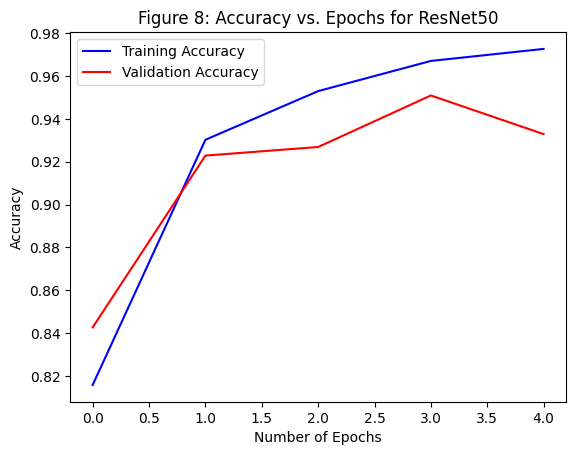

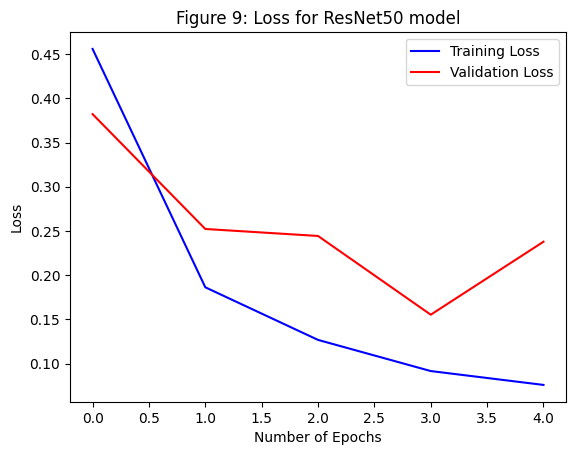

In [13]:
graphEpochs(resNetResults, "ResNet50", "8")

In [14]:
# Setting up DenseNet169 Model
denseNet = DenseNet169(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

for layers in denseNet.layers:
    layers.trainable=False

input_tensor = Input(shape = (224,224,3))
x = denseNet(input_tensor)

output = seqLayers(x)

model = Model(inputs = input_tensor, outputs = output)

# Training DenseNet169
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
denseNetResults = model.fit(training, validation_data = validation, epochs=1000, callbacks=[es])

51877672/51877672 [==============================] - 0s 0us/step
Epoch 1/1000
870/870 [==============================] - 91s 86ms/step - loss: 0.6093 - accuracy: 0.7487 - val_loss: 0.7189 - val_accuracy: 0.7580
Epoch 2/1000
870/870 [==============================] - 70s 81ms/step - loss: 0.2706 - accuracy: 0.8938 - val_loss: 0.3089 - val_accuracy: 0.8793
Epoch 3/1000
870/870 [==============================] - 70s 81ms/step - loss: 0.1808 - accuracy: 0.9317 - val_loss: 0.3952 - val_accuracy: 0.8717
Epoch 4/1000
870/870 [==============================] - 71s 81ms/step - loss: 0.1551 - accuracy: 0.9411 - val_loss: 0.7177 - val_accuracy: 0.8066
Epoch 5/1000
870/870 [==============================] - 70s 81ms/step - loss: 0.1157 - accuracy: 0.9562 - val_loss: 0.5862 - val_accuracy: 0.8382
Epoch 6/1000
870/870 [==============================] - 70s 81ms/step - loss: 0.1047 - accuracy: 0.9613 - val_loss: 0.1858 - val_accuracy: 0.9374
Epoch 7/1000
870/870 [==============================] - 71s

In [15]:
testModel(model)

248/248 [==============================] - 16s 65ms/step - loss: 0.2150 - accuracy: 0.9272

Accuracy: 0.9272


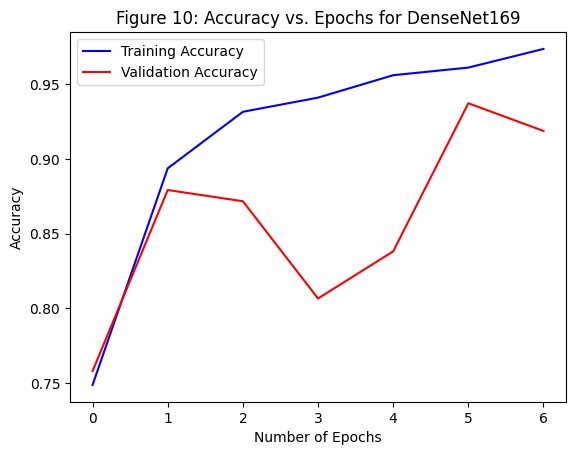

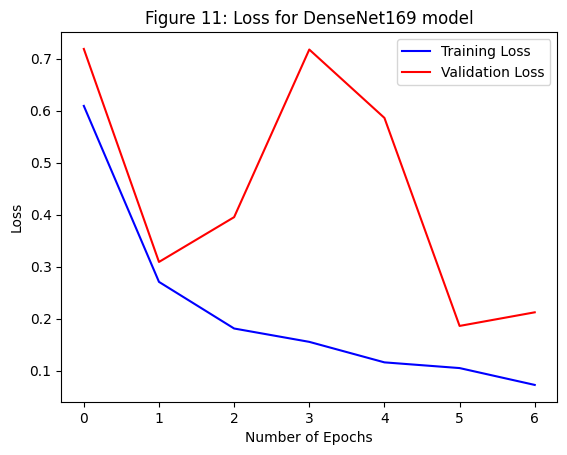

In [16]:
graphEpochs(denseNetResults, "DenseNet169", "10")

In [19]:
# Setting up VGG16 Model
vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

for layers in vgg.layers:
    layers.trainable=False

input_tensor = Input(shape = (224,224,3))
x = vgg(input_tensor)
output = seqLayers(x)

model = Model(inputs = input_tensor, outputs = output)

# Training VGG16
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
vgg_results = model.fit(training, validation_data = validation, epochs=1000, callbacks=[es])


Epoch 1/1000
870/870 [==============================] - 75s 81ms/step - loss: 0.5396 - accuracy: 0.7800 - val_loss: 0.4069 - val_accuracy: 0.8537
Epoch 2/1000
870/870 [==============================] - 70s 80ms/step - loss: 0.2314 - accuracy: 0.9122 - val_loss: 0.1834 - val_accuracy: 0.9339
Epoch 3/1000
870/870 [==============================] - 70s 80ms/step - loss: 0.1446 - accuracy: 0.9474 - val_loss: 0.1763 - val_accuracy: 0.9389
Epoch 4/1000
870/870 [==============================] - 70s 81ms/step - loss: 0.1193 - accuracy: 0.9562 - val_loss: 0.1753 - val_accuracy: 0.9414
Epoch 5/1000
870/870 [==============================] - 70s 80ms/step - loss: 0.0786 - accuracy: 0.9713 - val_loss: 0.1628 - val_accuracy: 0.9514
Epoch 6/1000
870/870 [==============================] - 70s 80ms/step - loss: 0.0855 - accuracy: 0.9689 - val_loss: 0.1827 - val_accuracy: 0.9449
Epoch 6: early stopping


In [20]:
testModel(model)

248/248 [==============================] - 16s 65ms/step - loss: 0.1775 - accuracy: 0.9483

Accuracy: 0.9483


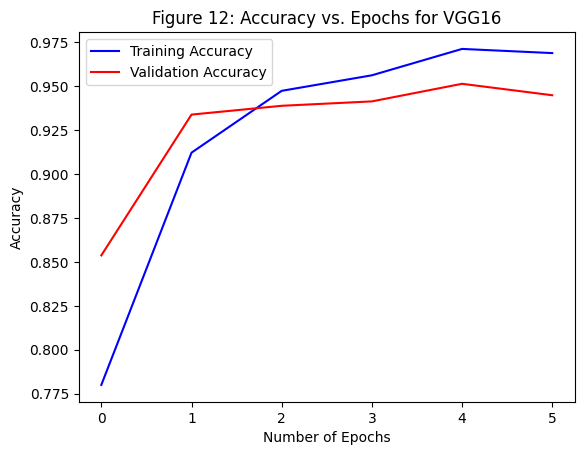

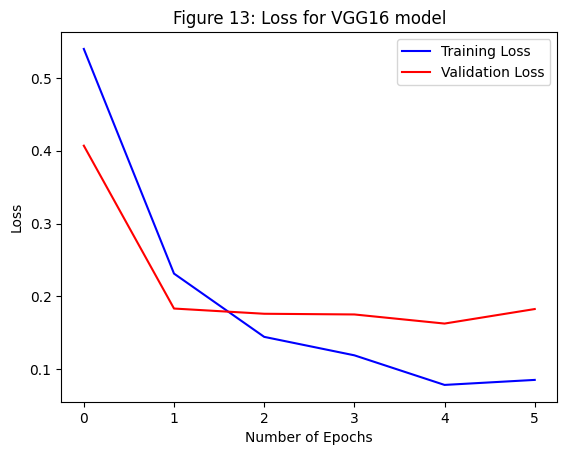

In [21]:
graphEpochs(vgg_results, "VGG16", "12")

In [23]:
# Setting up Xception Model
xception = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

for layers in xception.layers:
    layers.trainable=False

input_tensor = Input(shape = (224,224,3))
x = xception(input_tensor)

output = seqLayers(x)

model = Model(inputs = input_tensor, outputs = output)

# Training Xception

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
xceptionResults = model.fit(training, validation_data = validation, epochs=1000, callbacks=[es])

Epoch 1/1000
870/870 [==============================] - 80s 84ms/step - loss: 0.7505 - accuracy: 0.6894 - val_loss: 0.6490 - val_accuracy: 0.7340
Epoch 2/1000
870/870 [==============================] - 73s 84ms/step - loss: 0.4317 - accuracy: 0.8283 - val_loss: 0.4833 - val_accuracy: 0.8367
Epoch 3/1000
870/870 [==============================] - 72s 83ms/step - loss: 0.2933 - accuracy: 0.8847 - val_loss: 0.5622 - val_accuracy: 0.8382
Epoch 4/1000
870/870 [==============================] - 72s 83ms/step - loss: 0.2370 - accuracy: 0.9133 - val_loss: 0.5239 - val_accuracy: 0.8307
Epoch 5/1000
870/870 [==============================] - 72s 83ms/step - loss: 0.1870 - accuracy: 0.9314 - val_loss: 0.4851 - val_accuracy: 0.8868
Epoch 6/1000
870/870 [==============================] - 72s 83ms/step - loss: 0.1616 - accuracy: 0.9394 - val_loss: 0.5757 - val_accuracy: 0.8938
Epoch 6: early stopping


In [24]:
testModel(model)

248/248 [==============================] - 16s 66ms/step - loss: 0.4432 - accuracy: 0.9045

Accuracy: 0.9045


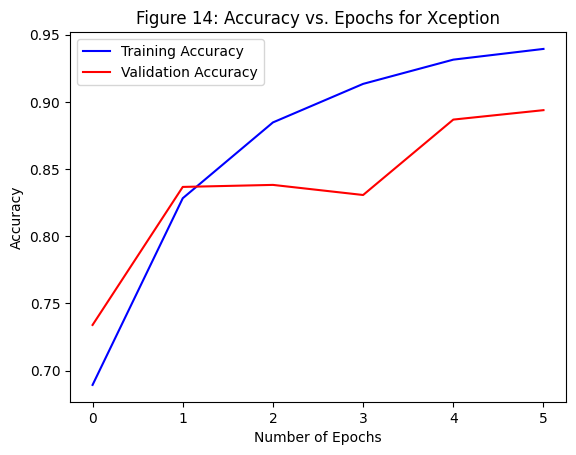

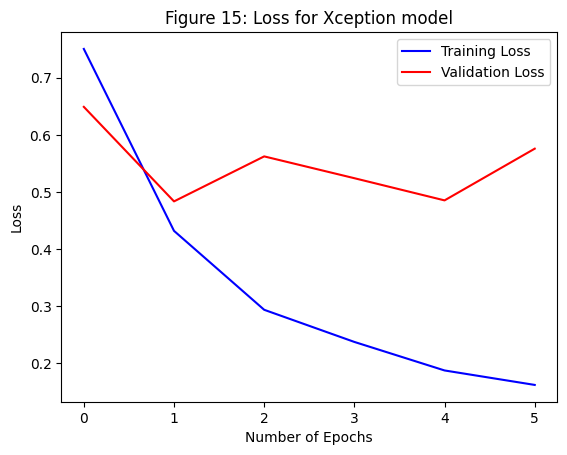

In [25]:
graphEpochs(xceptionResults, "Xception", "14")